# Make a Video of Defect Movement
Make a video where we color each defect based on its void

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colormaps
from rtdefects.io import load_file
from rtdefects.analysis import analyze_defects
from skimage.transform import resize, warp, EuclideanTransform
from skimage import measure
from functools import lru_cache
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import numpy as np
import shutil

Configuration

In [2]:
run_path = Path('../../runs/drift-corrected-625C/')
video_name = 'movie'

## Load in the Void Data
Load in the void tracks from a previous notebook and the overall summaries in each

In [3]:
void_tracks = pd.read_json(run_path / 'void_tracks.json')
void_tracks.head(2)

,start_frame,end_frame,total_frames,inferred_frames,positions,local_id,disp_from_start,max_disp,drift_rate,dist_traveled,total_traveled,movement_rate,radii,max_radius,min_radius,growth_rate
0,0,61,62,56,"[[3.7627118644, 745.3389830508], [3.8007532957...","[0, None, None, None, None, None, None, None, ...","[0.0, 0.0476965592, 0.0953931185, 0.1430896777...",3.201840,0.051643,"[0.0, 0.0476965592, 0.0953931185, 0.1430896777...",6.772452,0.109233,"[8.6672448413, 8.6422191577, 8.6171934741, 8.5...",9.236182,8.291860,0.015219
1,0,188,189,99,"[[493.6526946108, 266.8922155689], [492.622950...","[34, 38, 41, 34, 34, 37, 32, None, None, None,...","[0.0, 1.2335113262, 2.0486717212, 2.3058971942...",16.633257,0.088007,"[0.0, 1.2335113262, 2.2319189786, 3.089721106,...",134.976921,0.714164,"[14.5818724439, 12.4633552648, 13.3511623562, ...",14.581872,8.058239,0.002569


In [4]:
frame_data = pd.read_json(run_path / 'frame_data.json')
frame_data.head(2)

,void_frac,void_count,radii,radii_average,positions,run_time,created_time,completed_time,mask-path,image-path,rtt,detect_time,frame
0,0.027991,63,"[8.6672448413, 21.1100412282, 43.2038096999, 9...",20.234154,"[[3.7627118644, 745.3389830508], [7.5828571429...",0.312393,2023-04-20 12:50:41.216,2023-04-26 09:59:23.626,frames/masks/frame-0000.tiff,frames/frame-0000.tiff,11.955359,2023-04-26 09:59:11.671,0
1,0.029202,76,"[21.5871645515, 42.937755656, 9.5078918629, 14...",18.648929,"[[7.8169398907000005, 870.9972677596], [30.921...",0.327479,2023-04-20 12:50:41.216,2023-04-26 10:00:55.626,frames/masks/frame-0001.tiff,frames/frame-0001.tiff,103.953550,2023-04-26 09:59:11.672,1


## Make colors for each void
I want a color for each frame that are all from the same pallete, and that pallete to stand out from the gray background

In [5]:
cmap = colormaps['nipy_spectral']

Get a list of incremental colors, then shuffle so they are in a random order

In [6]:
colors = np.linspace(0, 1, len(void_tracks))
np.random.shuffle(colors)
colors = cmap(colors)

## Plot a Single Frame
Give each void in the frame a different color

In [7]:
frame = frame_data.iloc[10]

In [8]:
frame

void_frac                                                  0.028667
void_count                                                       67
radii             [20.8062837914, 43.0414165379, 11.1703838512, ...
radii_average                                             19.713451
positions         [[7.2794117647, 870.9], [30.3725085911, 308.89...
run_time                                                   0.325451
created_time                             2023-04-20 12:50:41.220000
completed_time                           2023-04-26 09:59:45.074000
mask-path                              frames/masks/frame-0010.tiff
image-path                                   frames/frame-0010.tiff
rtt                                                       33.402716
detect_time                              2023-04-26 09:59:11.671000
frame                                                            10
Name: 10, dtype: object

Load in the image and mask

In [9]:
image = load_file(run_path / frame['image-path'])

In [10]:
mask = load_file(run_path / frame['mask-path'])

Get the global ID for each void in this image

In [11]:
def get_global_id(frame_id: int) -> list[int]: 
    """Get the global void numbers for each void in this image
    
    Args:
        frame_id: ID for the frame in question
    Returns:
        Lookup of void number to overall number
    """
    
    # Determine how many voids I have
    void_count = frame_data.iloc[frame_id]['void_count']
    output = [0] * void_count
    
    # Get the tracks which could appear in this frame
    my_tracks = void_tracks.query(f'start_frame <= {frame_id} and end_frame >= {frame_id}')
    
    # For each void in the global, get the id for this frame
    for gid, track in my_tracks.iterrows():
        local_frame = frame_id - track['start_frame']
        local_id = track['local_id'][local_frame]
        if local_id is not None: # If a void was detected in this frame
            output[local_id] = gid
    return output

In [12]:
@lru_cache()
def load_and_label_mask(frame_id, use_global_ids: bool = True) -> np.ndarray:
    """Load a mask and assign the global id to each void
    
    Args:
        frame_id: Index of the frame
        use_global_ids: Whether to label voids based their global ID
    Returns:
        Array of label for each void and -1 for unlabelled pixels
    """
    
    # Load the mask rom disk
    frame = frame_data.iloc[frame_id]
    mask = load_file(run_path / frame['mask-path'])
    
    # Label the voids (establishes a local ID)
    _, labels = analyze_defects(mask > 0.5)
    labels -= 1  # These voids are 1-indexed, trackpy is 0-indexed
    if not use_global_ids:
        return labels
    
    # Update the IDs to the global ID
    global_ids = get_global_id(frame_id)
    output = labels.copy()
    for local_id, global_id in enumerate(global_ids):
        output[labels == local_id] = global_id
    
    return output
labels = load_and_label_mask(10)

Make a function to insert missing voids

In [13]:
def load_mask_with_interpolated_voids(frame_id: int) -> np.ndarray:
    """Load the mask, assign a global ID to present voids, add interpolate the position of voids which are missing"""
    
    # Load in our labels
    labels = load_and_label_mask(frame_id)
    
    # Find the missing voids
    possible_voids = void_tracks.query(f'start_frame <= {frame_id} and end_frame >= {frame_id}').index
    observed_voids = get_global_id(frame_id)
    missing_voids = set(possible_voids).difference(observed_voids)
    
    for missing_id in missing_voids:
        # Get the last frame in which this void appeared
        void_data = void_tracks.iloc[missing_id]
        my_frame = frame_id - void_data['start_frame']
        last_frame = max(i for i, x in enumerate(void_data['local_id'][:my_frame]) if x is not None)
        
        # Find the displacement between the void in that frame and now
        disp = np.subtract(void_data['positions'][my_frame], void_data['positions'][last_frame])  # Interpolated already
        
        # Move the void from the last frame by this displacement
        last_frame = load_and_label_mask(last_frame)
        last_frame = np.array(last_frame == missing_id, dtype=float)
        shifted_frame = warp(last_frame, EuclideanTransform(translation=disp).inverse)
        
        # Add it to our current frame
        labels[shifted_frame > 0.5] = missing_id
    return labels

Make a colormap for each void

In [14]:
def labels_to_colors(labels, colors) -> np.ndarray:
    """Generate an array where each pixel is colored according to its label
    
    Args:
        label: Mask where we've labeled defect by index
        colors: Colors to use for each index
    Returns:
        
    """
    # Make the output
    output = np.zeros((mask.shape[0], mask.shape[0], 4))
    
    # Set the color for each pixel
    for i, j in zip(*np.where(labels >= 0)):
        output[i, j, :] = colors[labels[i, j], :]
    return output
colored_mask = labels_to_colors(labels, colors)

Show the results on two nearly-adjacent frames

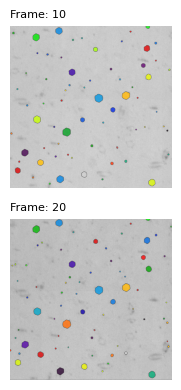

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(2, 4.))

for ax, fid in zip(axs, [10, 20]):
    # Get the images
    frame = frame_data.iloc[fid]
    image = load_file(run_path / frame['image-path'])
    labels = load_and_label_mask(fid, False)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot them
    ax.set_title(f'Frame: {fid}', loc='left', fontsize=8)
    im1 = ax.imshow(image, cmap='gray', alpha=0.5, extent=[0, 1, 0, 1])
    im2 = ax.imshow(colored_mask, alpha=0.8, extent=[0, 1, 0, 1])
    ax.axison = False
    
fig.tight_layout()
fig.savefig('figures/frames-with-local-ids.png', dpi=320)

In the first version, voids with the same position (i.e., the same void) have different colors

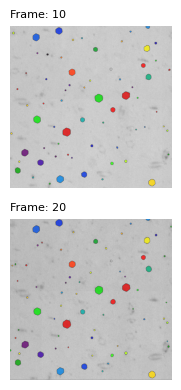

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(2, 4.))

for ax, fid in zip(axs, [10, 20]):
    # Get the images
    frame = frame_data.iloc[fid]
    image = load_file(run_path / frame['image-path'])
    labels = load_and_label_mask(fid)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot them
    ax.set_title(f'Frame: {fid}', loc='left', fontsize=8)
    im1 = ax.imshow(image, cmap='gray', alpha=0.5, extent=[0, 1, 0, 1])
    im2 = ax.imshow(colored_mask, alpha=0.8, extent=[0, 1, 0, 1])
    ax.axison = False
    
fig.tight_layout()
fig.savefig('figures/frames-with-global-ids.png', dpi=320)

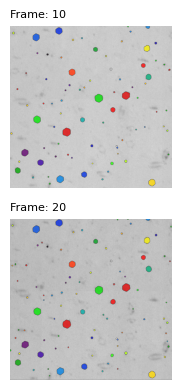

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(2, 4.))

for ax, fid in zip(axs, [10, 20]):
    # Get the images
    frame = frame_data.iloc[fid]
    image = load_file(run_path / frame['image-path'])
    labels = load_mask_with_interpolated_voids(fid)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot them
    ax.set_title(f'Frame: {fid}', loc='left', fontsize=8)
    im1 = ax.imshow(image, cmap='gray', alpha=0.5, extent=[0, 1, 0, 1])
    im2 = ax.imshow(colored_mask, alpha=0.8, extent=[0, 1, 0, 1])
    ax.axison = False
    
fig.tight_layout()
fig.savefig('figures/frames-with-global-ids-interpolated.png', dpi=320)

The above shows how we can 

## Make a Video
Go through each frame and make a video [using a function-based strategy](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html#matplotlib.animation.FuncAnimation)

342it [1:04:47,  6.61s/it]                                                                                                                                                                                                                                                                

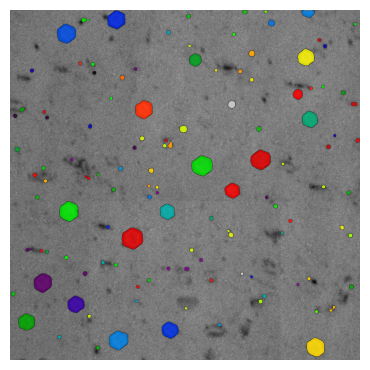

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.axison=False
frame_dir = Path(f"videos/{video_name}-frames/")       
if frame_dir.exists():
    shutil.rmtree(frame_dir)
frame_dir.mkdir(parents=True)

pbar = tqdm(total=len(frame_data))
im1 = ax.imshow(image, cmap='gray', extent=[0, 1, 0, 1])
im2 = ax.imshow(colored_mask, alpha=0.9, extent=[0, 1, 0, 1])

def plot_frame(i):
    pbar.update(1)
    # Get the frames
    frame = frame_data.iloc[i]
    image = load_file(run_path / frame['image-path'])
    labels = load_mask_with_interpolated_voids(i)
    colored_mask = labels_to_colors(labels, colors)
    
    # Plot both
    im1.set_data(image)
    im2.set_data(colored_mask)
    
    # Write out the current frame
    fig.savefig(frame_dir / f'frame-{i:04d}.tiff', dpi=320, pil_kwargs={"compression": "tiff_lzw"})
    return im1, im2
    
fig.tight_layout(pad=0)

ani = animation.FuncAnimation(fig, plot_frame, frames=len(frame_data), interval=3000 / len(frame_data), blit=True)
writer = animation.FFMpegWriter(fps=15, bitrate=16000)
ani.save(f"videos/{video_name}.mp4", writer=writer, dpi=320)